In [2]:
import sys
from pathlib import Path
import os

def is_google_colab() -> bool:
    if "google.colab" in str(get_ipython()):
        return True
    return False

def clone_repository() -> None:
    !git clone https://github.com/featurestorebook/mlfs-book.git
    %cd mlfs-book

def install_dependencies() -> None:
    !pip install --upgrade uv
    !uv pip install --all-extras --system --requirement pyproject.toml

if is_google_colab():
    clone_repository()
    install_dependencies()
    root_dir = str(Path().absolute())
    print("Google Colab environment")
else:
    root_dir = Path().absolute()
    # Strip ~/notebooks/ccfraud from PYTHON_PATH if notebook started in one of these subdirectories
    if root_dir.parts[-1:] == ('airquality',):
        root_dir = Path(*root_dir.parts[:-1])
    if root_dir.parts[-1:] == ('notebooks',):
        root_dir = Path(*root_dir.parts[:-1])
    root_dir = str(root_dir) 
    print("Local environment")

# Add the root directory to the `PYTHONPATH` to use the `recsys` Python module from the notebook.
if root_dir not in sys.path:
    sys.path.append(root_dir)
print(f"Added the following directory to the PYTHONPATH: {root_dir}")
    
# Set the environment variables from the file <root_dir>/.env
from mlfs import config
if os.path.exists(f"{root_dir}/.env"):
    settings = config.HopsworksSettings(_env_file=f"{root_dir}/.env")

Local environment
Added the following directory to the PYTHONPATH: d:\KTH\Scalable Machine Learning and Deep Learning\LAB\mlfs-book
HopsworksSettings initialized!


# <span style="font-width:bold; font-size: 3rem; color:#333;">Training Pipeline</span>

## 🗒️ This notebook is divided into the following sections:

1. Select features for the model and create a Feature View with the selected features
2. Create training data using the feature view
3. Train model
4. Evaluate model performance
5. Save model to model registry

### <span style='color:#ff5f27'> 📝 Imports

In [3]:
from datetime import datetime, timedelta
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from xgboost import plot_importance
from sklearn.metrics import mean_squared_error, r2_score
import hopsworks
from mlfs.airquality import util
import json

import warnings
warnings.filterwarnings("ignore")

## <span style="color:#ff5f27;"> 📡 Connect to Hopsworks Feature Store </span>

In [5]:
# Check if HOPSWORKS_API_KEY env variable is set or if it is set in ~/.env
if settings.HOPSWORKS_API_KEY is not None:
    api_key = settings.HOPSWORKS_API_KEY.get_secret_value()
    os.environ['HOPSWORKS_API_KEY'] = api_key
project = hopsworks.login()
fs = project.get_feature_store() 

secrets = hopsworks.get_secrets_api()
location_str = secrets.get_secret("SENSOR_LOCATION_JSON").value
location = json.loads(location_str)
country=location['country']
city=location['city']
#street=location['street']
sensors = location['sensors']  # 新增：读取所有传感器

print(f"Training model for {city} with {len(sensors)} sensors:")
for s in sensors:
    print(f"  - {s['street']}")

2025-11-13 16:16:16,112 INFO: Closing external client and cleaning up certificates.
Connection closed.
2025-11-13 16:16:16,130 INFO: Initializing external client
2025-11-13 16:16:16,131 INFO: Base URL: https://c.app.hopsworks.ai:443


2025-11-13 16:16:17,586 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1298583
Training model for tampere with 5 sensors:
  - tampere
  - kaleva
  - pirkankatu
  - epila-2
  - linja-autoasema


In [6]:
# ========== Step 3: 获取Feature Groups（修改版本号）==========
air_quality_fg = fs.get_feature_group(
    name='air_quality_sensors',  # 确认你的FG名称
    version=1,
)

weather_fg = fs.get_feature_group(
    name='weather_sensors',  # 确认你的FG名称
    version=1,
)

print("✅ Feature Groups retrieved")

✅ Feature Groups retrieved


--- 

## <span style="color:#ff5f27;"> 🖍 Feature View Creation and Retrieving </span>

In [ ]:
# ========== Step 4: 选择特征（重要修改）==========
# 包含lag features和street
selected_features = air_quality_fg.select([
    'pm25', 'pm25_lag_1', 'pm25_lag_2', 'pm25_lag_3', 
    'street', 'date'  # 新增：street作为特征
]).join(weather_fg.select_all(), on=['city'])

### Feature Views

`Feature Views` are selections of features from different **Feature Groups** that make up the input and output API (or schema) for a model. A **Feature Views** can create **Training Data** and also be used in Inference to retrieve inference data.

The Feature Views allows a schema in form of a query with filters, defining a model target feature/label and additional transformation functions (declarative feature encoding).

In order to create Feature View we can use `FeatureStore.get_or_create_feature_view()` method.

You can specify the following parameters:

- `name` - name of a feature group.

- `version` - version of a feature group.

- `labels`- our target variable.

- `transformation_functions` - declarative feature encoding (not used here)

- `query` - selected features/labels for the model 

In [8]:
# ========== Step 5: 创建Feature View ==========
feature_view = fs.get_or_create_feature_view(
    name='air_quality_fv_multisensor',  # 新名称
    description="Multi-sensor air quality with lag features - Tampere",
    version=1,
    labels=['pm25'],
    query=selected_features,
)

print("✅ Feature View created")

2025-11-13 16:17:35,309 WARNING: Ambiguous features detected during query construction.The feature `date` is present in feature groups ['air_quality_sensors version 1', 'weather_sensors version 1']. Automatically prefixing features selected using these feature groups with the feature group name.
Feature view created successfully, explore it at 
https://c.app.hopsworks.ai:443/p/1298583/fs/1286215/fv/air_quality_fv_multisensor/version/1
✅ Feature View created


## <span style="color:#ff5f27;">🪝 Split the training data into train/test data sets </span>

We use a time-series split here, with training data before this date `start_date_test_data` and test data after this date

In [26]:
start_date_test_data = "2025-05-01"
# Convert string to datetime object
test_start = datetime.strptime(start_date_test_data, "%Y-%m-%d")

In [27]:
X_train, X_test, y_train, y_test = feature_view.train_test_split(
    test_start=test_start
)
print(f"Training samples: {len(X_train)}")
print(f"Test samples: {len(X_test)}")
print(f"Original columns: {X_train.columns.tolist()}")

# 保存date列用于后续分析
X_train_dates = X_train['date']
X_test_dates = X_test['date']

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (2.70s) 
2025-11-13 16:38:40,830 INFO: Provenance cached data - overwriting last accessed/created training dataset from 2 to 3.
Training samples: 17977
Test samples: 971
Original columns: ['pm25_lag_1', 'pm25_lag_2', 'pm25_lag_3', 'street', 'date', 'weather_sensors_date', 'weather_sensors_temperature_2m_mean', 'weather_sensors_precipitation_sum', 'weather_sensors_wind_speed_10m_max', 'weather_sensors_wind_direction_10m_dominant', 'weather_sensors_city']


In [28]:
# 删除所有date相关列
date_cols = [col for col in X_train.columns if 'date' in col.lower()]
print(f"Removing date columns: {date_cols}")

X_train = X_train.drop(columns=date_cols)
X_test = X_test.drop(columns=date_cols)

# 删除city列（所有行都一样）
if 'weather_sensors_city' in X_train.columns:
    X_train = X_train.drop(columns=['weather_sensors_city'])
    X_test = X_test.drop(columns=['weather_sensors_city'])

print(f"Final columns: {X_train.columns.tolist()}")
print(f"Dtypes:\n{X_train.dtypes}")

Removing date columns: ['date', 'weather_sensors_date']
Final columns: ['pm25_lag_1', 'pm25_lag_2', 'pm25_lag_3', 'street', 'weather_sensors_temperature_2m_mean', 'weather_sensors_precipitation_sum', 'weather_sensors_wind_speed_10m_max', 'weather_sensors_wind_direction_10m_dominant']
Dtypes:
pm25_lag_1                                     float32
pm25_lag_2                                     float32
pm25_lag_3                                     float32
street                                          object
weather_sensors_temperature_2m_mean            float32
weather_sensors_precipitation_sum              float32
weather_sensors_wind_speed_10m_max             float32
weather_sensors_wind_direction_10m_dominant    float32
dtype: object


In [29]:
X_train

,pm25_lag_1,pm25_lag_2,pm25_lag_3,street,weather_sensors_temperature_2m_mean,weather_sensors_precipitation_sum,weather_sensors_wind_speed_10m_max,weather_sensors_wind_direction_10m_dominant
0,18.0,14.0,22.0,kaleva,3.517333,1.7,19.296135,19.292925
1,11.0,11.0,19.0,epila-2,3.517333,1.7,19.296135,19.292925
2,20.0,15.0,26.0,tampere,3.517333,1.7,19.296135,19.292925
3,20.0,15.0,25.0,linja-autoasema,3.517333,1.7,19.296135,19.292925
4,12.0,11.0,11.0,epila-2,3.652750,0.1,9.957108,8.006311
...,...,...,...,...,...,...,...,...
17972,7.0,17.0,9.0,kaleva,4.459000,0.0,11.252519,21.092421
17973,14.0,14.0,10.0,epila-2,4.459000,0.0,11.252519,21.092421
17974,13.0,15.0,10.0,linja-autoasema,4.459000,0.0,11.252519,21.092421
17975,15.0,21.0,13.0,tampere,4.459000,0.0,11.252519,21.092421


In [30]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17977 entries, 0 to 17976
Data columns (total 8 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   pm25_lag_1                                   17977 non-null  float32
 1   pm25_lag_2                                   17977 non-null  float32
 2   pm25_lag_3                                   17977 non-null  float32
 3   street                                       17977 non-null  object 
 4   weather_sensors_temperature_2m_mean          17977 non-null  float32
 5   weather_sensors_precipitation_sum            17977 non-null  float32
 6   weather_sensors_wind_speed_10m_max           17977 non-null  float32
 7   weather_sensors_wind_direction_10m_dominant  17977 non-null  float32
dtypes: float32(7), object(1)
memory usage: 772.4+ KB


In [31]:
y_train

,pm25
0,17.0
1,12.0
2,21.0
3,21.0
4,20.0
...,...
17972,8.0
17973,13.0
17974,12.0
17975,14.0


The `Feature View` is now saved in Hopsworks and you can retrieve it using `FeatureStore.get_feature_view(name='...', version=1)`.

---

## <span style="color:#ff5f27;">🧬 Modeling</span>

We will train a regression model to predict pm25 using our 4 features (wind_speed, wind_dir, temp, precipitation)

In [32]:
# ========== Step 7: 处理categorical特征（street）==========
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# 识别categorical列
categorical_features = ['street']
numeric_features = [col for col in X_train.columns if col not in categorical_features]

# 创建预处理pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough'  # 数值特征保持不变
)

In [34]:
# ========== Step 8: 训练模型 ==========
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score

# 创建完整pipeline（预处理+模型）
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', XGBRegressor(n_estimators=100, max_depth=5, random_state=42))
])

# 训练
print("\nTraining model...")
model_pipeline.fit(X_train, y_train)

# 预测
y_pred = model_pipeline.predict(X_test)

# 评估
mse = mean_squared_error(y_test.iloc[:,0], y_pred)
r2 = r2_score(y_test.iloc[:,0], y_pred)

print(f"\nModel Performance:")
print(f"MSE: {mse:.4f}")
print(f"R²:  {r2:.4f}")


Training model...

Model Performance:
MSE: 50.7300
R²:  0.5957


In [35]:
# ========== Step 9: 结果分析 ==========
results_df = y_test.copy()
results_df['predicted_pm25'] = y_pred
results_df['date'] = X_test_dates.values
results_df = results_df.sort_values(by=['date'])

print("\nSample predictions:")
results_df.head(10)


Sample predictions:


,pm25,predicted_pm25,date
17977,11.0,17.586023,2025-05-01 00:00:00+00:00
17978,9.0,12.594626,2025-05-01 00:00:00+00:00
17979,12.0,16.721729,2025-05-01 00:00:00+00:00
17980,11.0,23.084501,2025-05-01 00:00:00+00:00
17981,13.0,14.709755,2025-05-01 00:00:00+00:00
17982,12.0,10.500219,2025-05-02 00:00:00+00:00
17983,13.0,15.805037,2025-05-02 00:00:00+00:00
17984,13.0,13.313016,2025-05-02 00:00:00+00:00
17985,7.0,16.589897,2025-05-02 00:00:00+00:00
17986,11.0,15.791402,2025-05-02 00:00:00+00:00


In [36]:
# ========== 创建目录 ==========
model_dir = "air_quality_model_multisensor"  # 新名字
if not os.path.exists(model_dir):
    os.mkdir(model_dir)
images_dir = model_dir + "/images"
if not os.path.exists(images_dir):
    os.mkdir(images_dir)

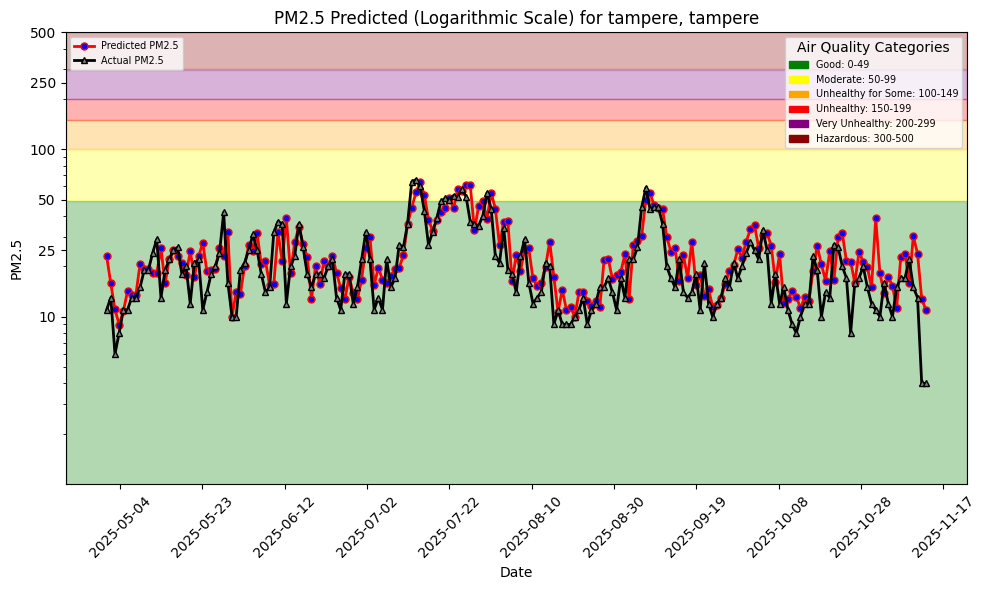

✅ Saved hindcast for tampere


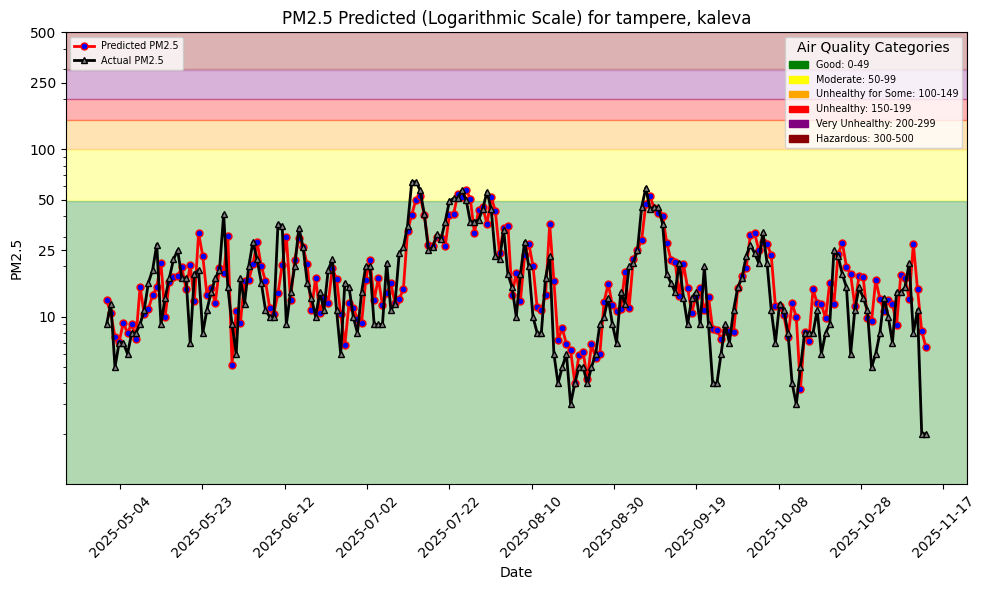

✅ Saved hindcast for kaleva


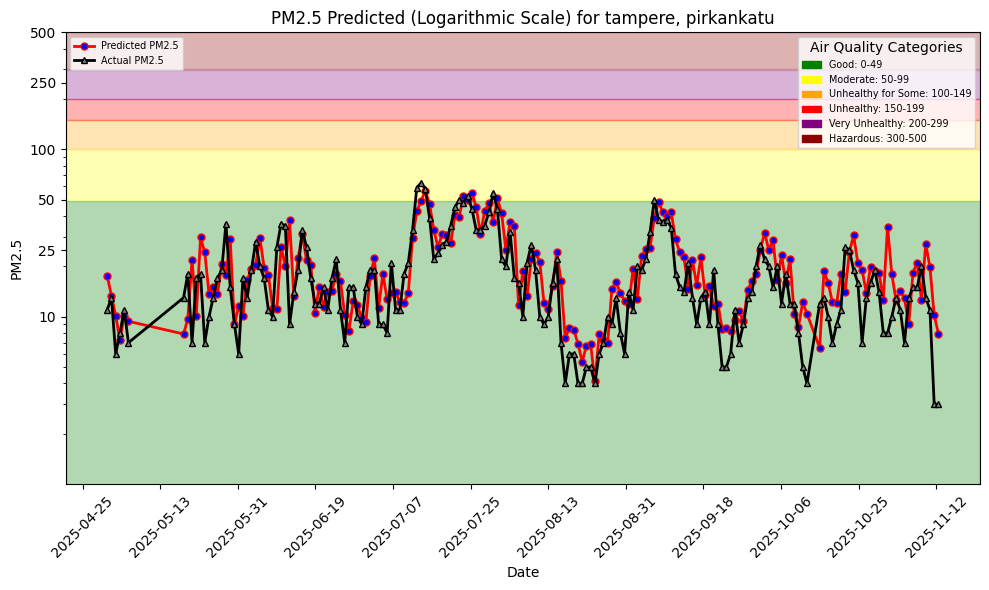

✅ Saved hindcast for pirkankatu


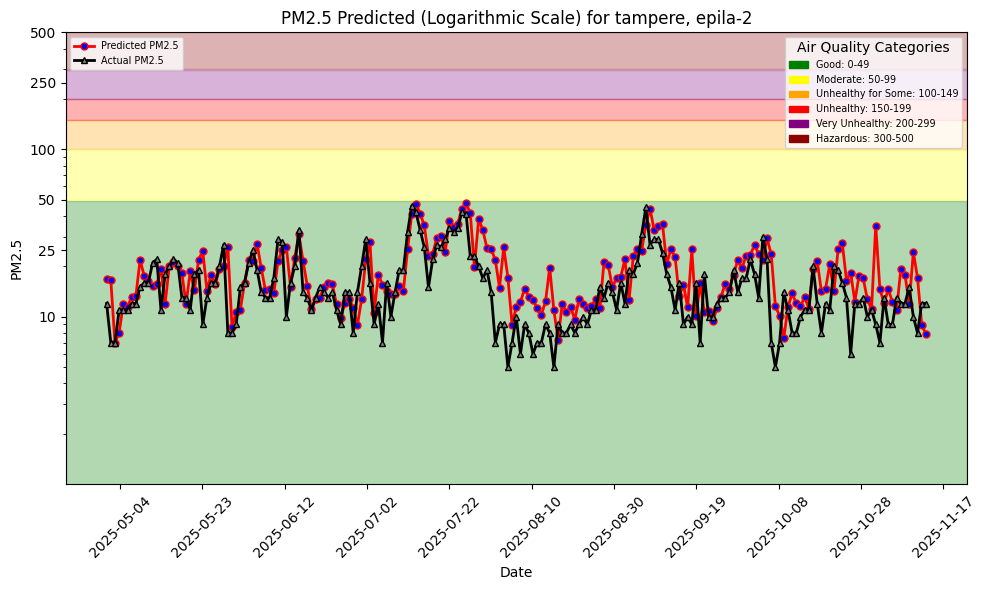

✅ Saved hindcast for epila-2


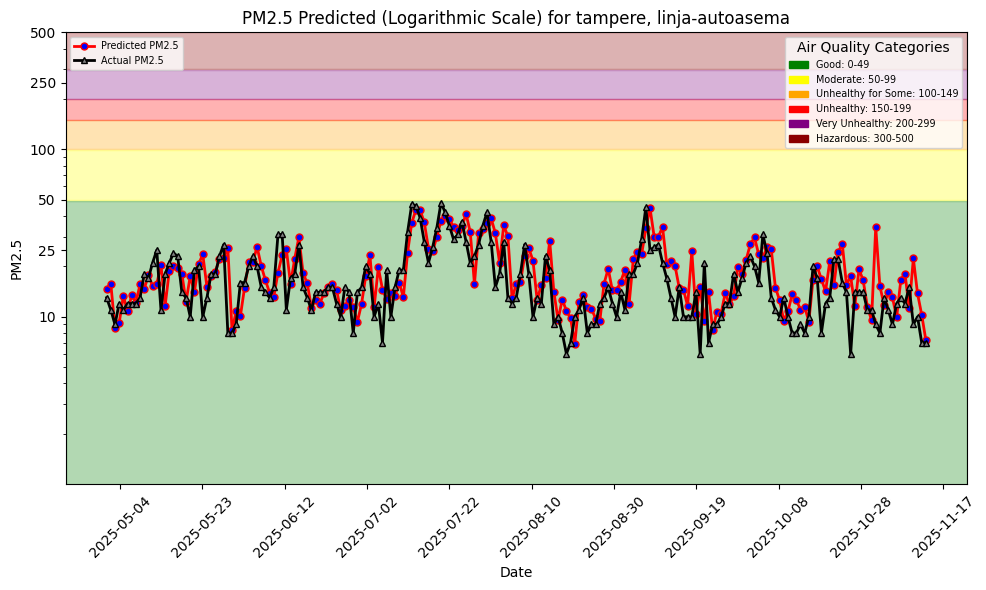

✅ Saved hindcast for linja-autoasema


In [37]:
# ========== 绘制hindcast（循环5个传感器）==========
import matplotlib.pyplot as plt

for sensor_street in sensors:
    street_name = sensor_street['street']
    
    # 筛选该传感器的预测结果
    sensor_results = results_df[results_df.index.isin(
        X_test[X_test['street'] == street_name].index
    )].copy()
    
    if len(sensor_results) > 0:
        file_path = f"{images_dir}/pm25_hindcast_{street_name}.png"
        plt_obj = util.plot_air_quality_forecast(
            city, street_name, sensor_results, file_path, hindcast=True
        )
        plt_obj.show()
        print(f"✅ Saved hindcast for {street_name}")

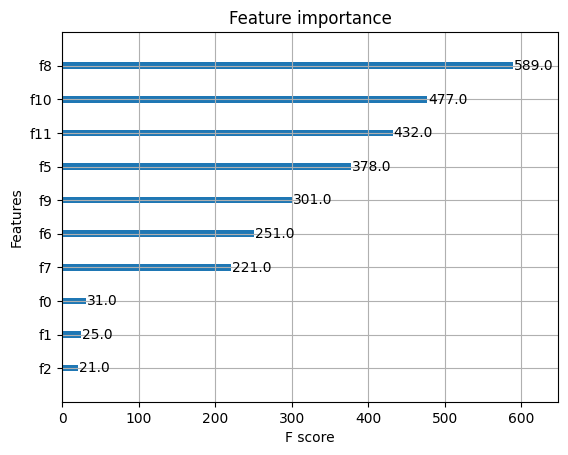

In [38]:
# ========== 特征重要性（从Pipeline提取）==========
from xgboost import plot_importance

# 获取XGBoost模型
xgb_model = model_pipeline.named_steps['regressor']

# 绘制
plot_importance(xgb_model, max_num_features=10)
feature_importance_path = images_dir + "/feature_importance.png"
plt.savefig(feature_importance_path)
plt.show()

---

## <span style='color:#ff5f27'>🗄 Model Registry</span>

One of the features in Hopsworks is the model registry. This is where you can store different versions of models and compare their performance. Models from the registry can then be served as API endpoints.

In [40]:
# ========== 保存模型（保存Pipeline）==========
import joblib

# 保存完整pipeline
joblib.dump(model_pipeline, model_dir + "/model_pipeline.pkl")

# 也保存XGBoost模型（兼容性）
xgb_model.save_model(model_dir + "/model.json")

# 保存LabelEncoder信息（如果用了）
# 保存street映射关系
import json
street_mapping = {i: street for i, street in enumerate(X_train['street'].unique())}
with open(model_dir + "/street_mapping.json", "w") as f:
    json.dump(street_mapping, f)


In [41]:
# ========== 注册到Model Registry ==========
res_dict = { 
    "MSE": str(mse),
    "R_squared": str(r2),
    "num_sensors": str(len(sensors)),
}

In [43]:
mr = project.get_model_registry()

aq_model = mr.python.create_model(
    name="air_quality_xgboost_model_multisensor",  # 新名字
    metrics=res_dict,
    feature_view=feature_view,
    description=f"Multi-sensor Air Quality predictor for {city} ({len(sensors)} sensors)",
)

aq_model.save(model_dir)
print(f"\n✅ Model saved to Hopsworks Model Registry!")

  0%|          | 0/6 [00:00<?, ?it/s]

Uploading d:\KTH\Scalable Machine Learning and Deep Learning\LAB\mlfs-book\notebooks\airquality\air_quality_mo…

Uploading d:\KTH\Scalable Machine Learning and Deep Learning\LAB\mlfs-book\notebooks\airquality\air_quality_mo…

Uploading d:\KTH\Scalable Machine Learning and Deep Learning\LAB\mlfs-book\notebooks\airquality\air_quality_mo…

Uploading d:\KTH\Scalable Machine Learning and Deep Learning\LAB\mlfs-book\notebooks\airquality\air_quality_mo…

Uploading d:\KTH\Scalable Machine Learning and Deep Learning\LAB\mlfs-book\notebooks\airquality\air_quality_mo…

Uploading d:\KTH\Scalable Machine Learning and Deep Learning\LAB\mlfs-book\notebooks\airquality\air_quality_mo…

Uploading d:\KTH\Scalable Machine Learning and Deep Learning\LAB\mlfs-book\notebooks\airquality\air_quality_mo…

Uploading d:\KTH\Scalable Machine Learning and Deep Learning\LAB\mlfs-book\notebooks\airquality\air_quality_mo…

Uploading d:\KTH\Scalable Machine Learning and Deep Learning\LAB\mlfs-book\notebooks\airquality\air_quality_mo…

Uploading d:\KTH\Scalable Machine Learning and Deep Learning\LAB\mlfs-book\notebooks\airquality\model_schema.j…

Model created, explore it at https://c.app.hopsworks.ai:443/p/1298583/models/air_quality_xgboost_model_multisensor/1

✅ Model saved to Hopsworks Model Registry!


---
## <span style="color:#ff5f27;">⏭️ **Next:** Part 04: Batch Inference</span>

In the following notebook you will use your model for Batch Inference.
